In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [3]:
import torch
import torch.nn as nn

from torchvision.datasets import OxfordIIITPet
from torchvision.transforms.functional import to_tensor, to_pil_image, resize, pil_to_tensor
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

#Contents:

1. We'll make a Image segmentation model for OxfordIIITPet dataset

About OxfordIIITPet:

The dataset consists of images of pets. each pixel's corresponding mask value is as follows:

- 1 = Pet pixel.
- 2 = background pixel.
- 3 = border around the pet.


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

In [4]:
color_map = [
    (0, 0, 0),
    (255, 0, 0),
    (255, 255, 255)
]

color_map = torch.Tensor(color_map).type(torch.uint8).unsqueeze(dim=-1)

def get_segmentation_mask_disp_img(img: torch.Tensor):

  disp_shape = [3]+list(img.shape)[1:]
  disp_img = torch.full(disp_shape, 0).type(torch.uint8)

  for cls in [0, 1, 2]:  # we will use the range 0 to 2 instead of 1 to 3 for mask pixel values.

    mask = (img==cls).squeeze(dim=0)
    disp_img[:, mask] = color_map[cls]

  return disp_img

In [131]:
class SubtractOne(nn.Module):

  def forward(self, img):
    return img-1

In [135]:
target_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    SubtractOne()  # need to subtract 1 from the target to bring it from 1-3 range to 0-2 range
])

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])


train_dataset = OxfordIIITPet(root='data/train/', split="trainval",
                              target_types="segmentation", download=True,
                              transform=img_transforms, target_transform=target_transforms)
test_dataset  = OxfordIIITPet(root='data/test/' , split="test",
                              target_types="segmentation", download=True,
                              transform=img_transforms, target_transform=target_transforms)

In [136]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True )
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False)

In [137]:
class CustomSegModel(nn.Module):  # Unet architecture based
    def __init__(self, in_channels, out_channels):
        super(CustomSegModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

In [97]:
# Example usage
in_channels = 3  # for RGB images (3 channels)
out_channels = 3  # for 3 classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomSegModel(in_channels, out_channels).to(device)

### Pre-training performance

In [138]:
test_imgs = []
test_gts = []

for i in range(10):

  img, gt = test_dataset[i]
  test_imgs.append(img)
  test_gts.append(gt)

test_gts = [get_segmentation_mask_disp_img(gt) for gt in test_gts]

test_preds = []

with torch.no_grad():

  for i in range(10):
    pred = model(test_imgs[i].unsqueeze(0).to(device)).argmax(dim=1)
    test_preds.append(pred)

test_preds = [get_segmentation_mask_disp_img(pred) for pred in test_preds]

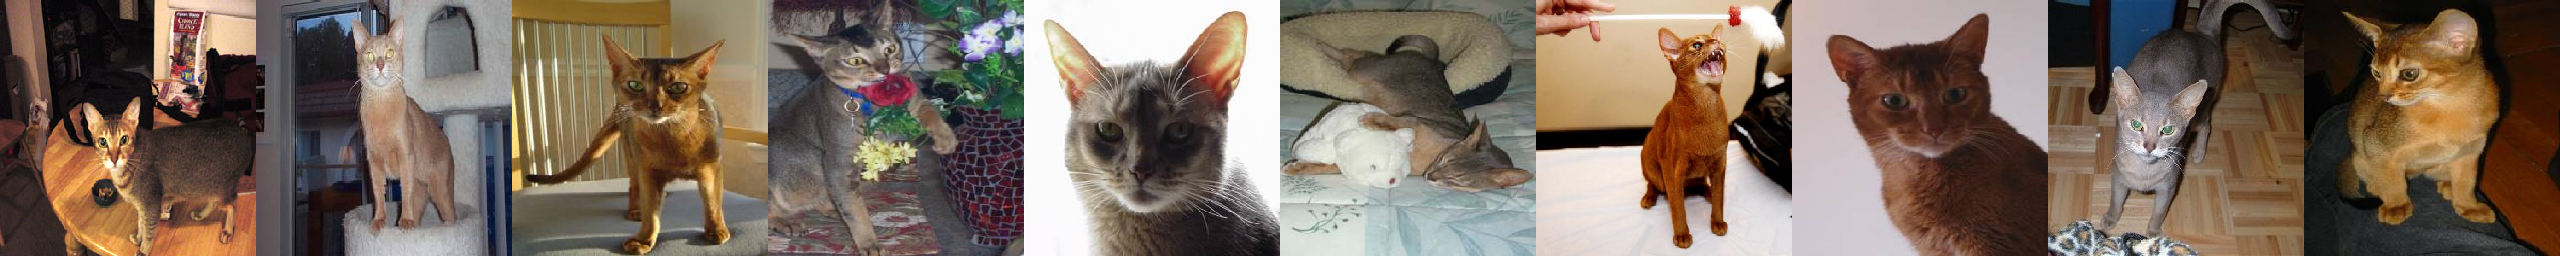

In [100]:
# Images
to_pil_image(torch.cat(test_imgs, dim=-1))

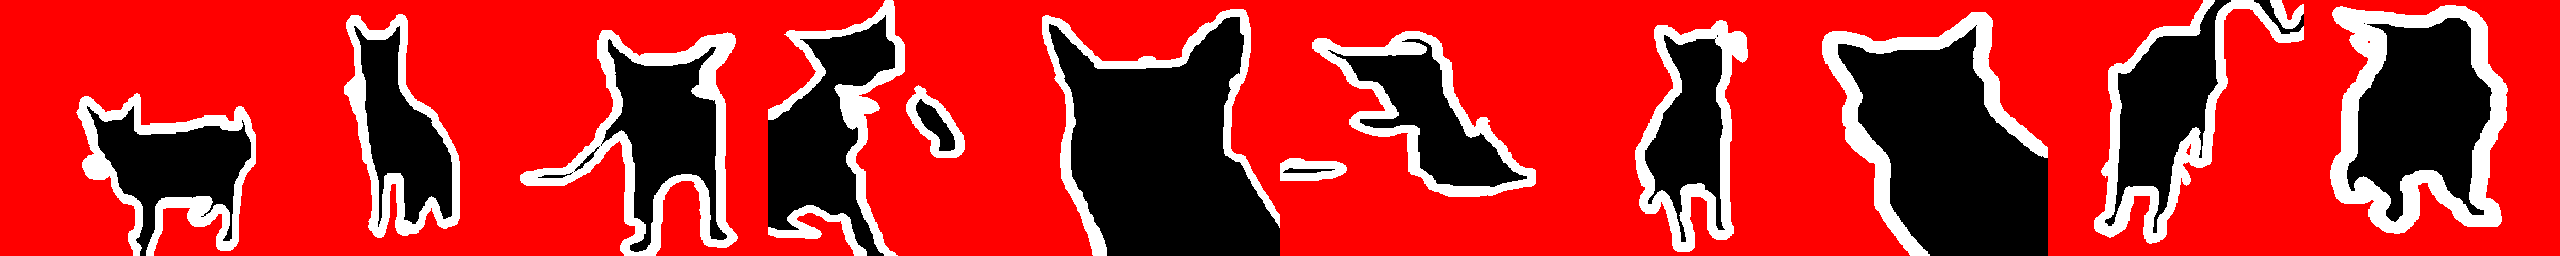

In [130]:
# Ground Truths
to_pil_image(torch.cat(test_gts, dim=-1))

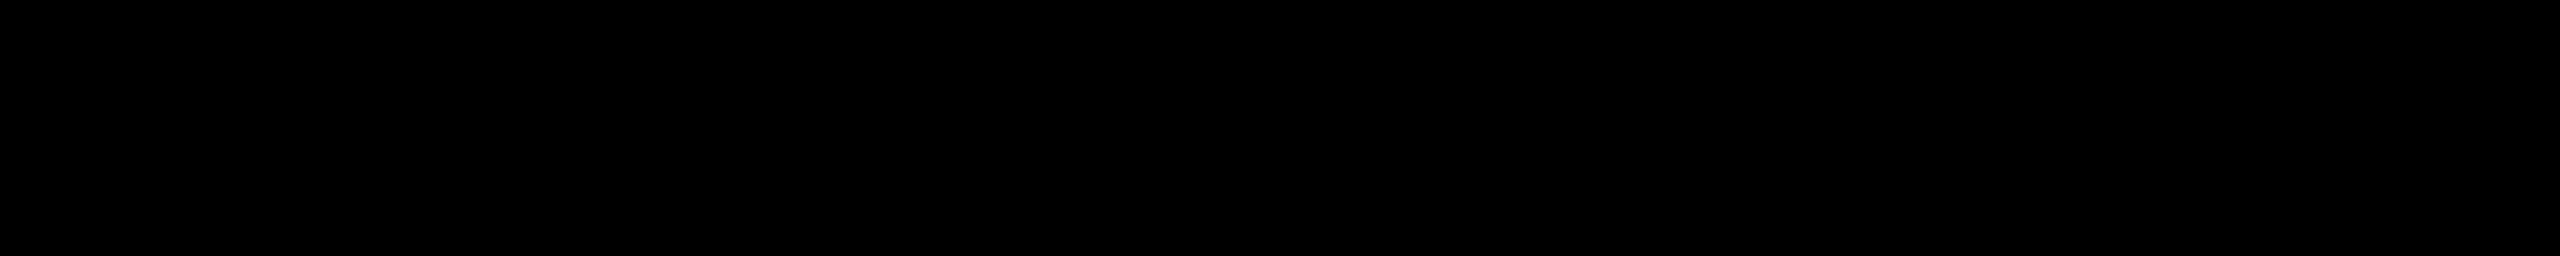

In [102]:
# Predicted masks
to_pil_image(torch.cat(test_preds, dim=-1))

In [103]:
num_epochs = 10
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(reduction='mean')

print(f'Using device {device}')

Using device cuda


### Training

In [104]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    batch_y = batch_y.squeeze(dim=1).type(torch.long)

    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)
      val_batch_y = val_batch_y.squeeze(dim=1).type(torch.long)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}.')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=0.9701221652652906, val_loss=0.8770646541928946.
Epoch: 1, train_loss=0.8203470328579778, val_loss=0.8029332158350431.
Epoch: 2, train_loss=0.7662376191305078, val_loss=0.7464850624369873.
Epoch: 3, train_loss=0.729029685518016, val_loss=0.7221021502925772.
Epoch: 4, train_loss=0.6985930764156839, val_loss=0.6749659666380853.
Epoch: 5, train_loss=0.6400386965793112, val_loss=0.6030734192126127.
Epoch: 6, train_loss=0.5746836273566537, val_loss=0.5287844784888821.
Epoch: 7, train_loss=0.5143159008544425, val_loss=0.49734204730567766.
Epoch: 8, train_loss=0.48905792495478756, val_loss=0.45300345338472847.
Epoch: 9, train_loss=0.4486425573411195, val_loss=0.42610731619390163.
Training complete on device cuda.
CPU times: user 41min 37s, sys: 15.5 s, total: 41min 52s
Wall time: 41min 57s


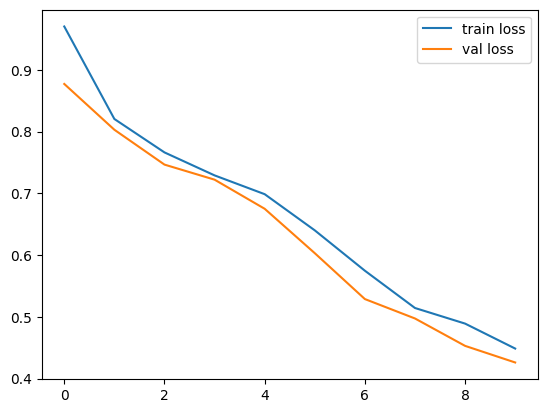

In [120]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')

plt.legend()
plt.show()

### Post-training performance

The model still has room to improve but we'll stop here for now

In [139]:
test_preds = []

with torch.no_grad():

  for i in range(10):
    pred = model(test_imgs[i].unsqueeze(0).to(device)).argmax(dim=1)
    test_preds.append(pred)

test_preds = [get_segmentation_mask_disp_img(pred) for pred in test_preds]

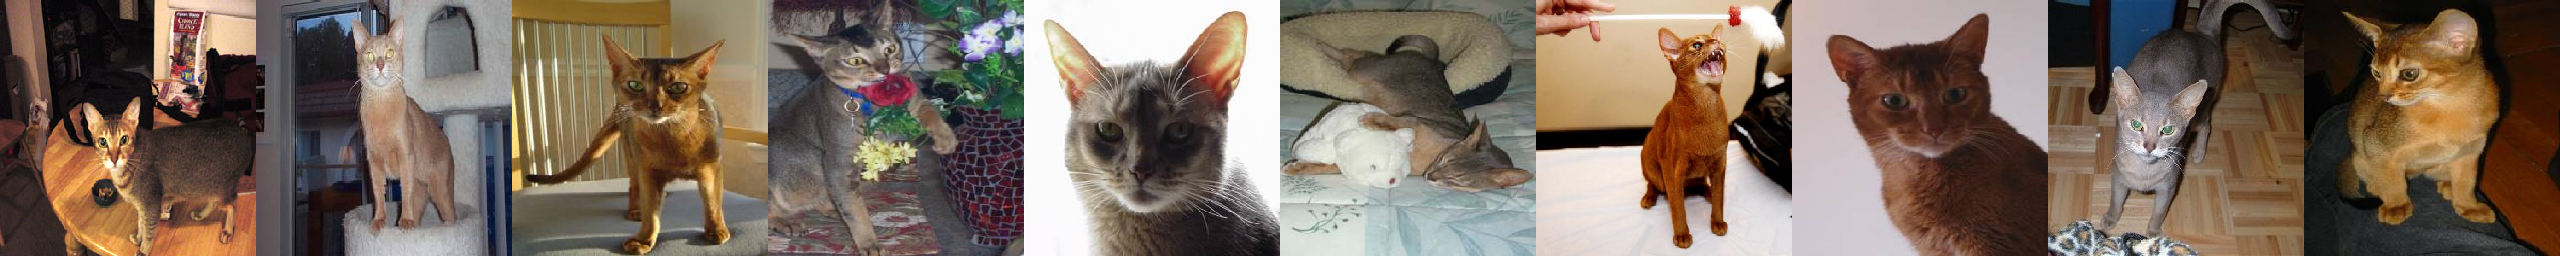

In [140]:
# Images
to_pil_image(torch.cat(test_imgs, dim=-1))

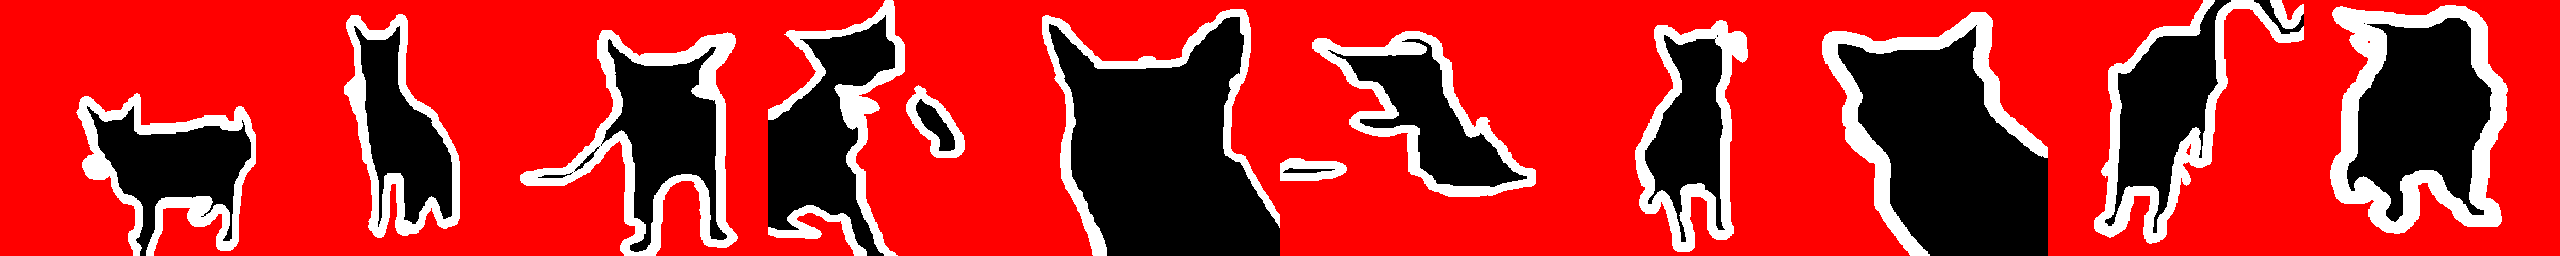

In [141]:
# Ground Truths
to_pil_image(torch.cat(test_gts, dim=-1))

In [ ]:
# Predicted masks
to_pil_image(torch.cat(test_preds, dim=-1))